# Wildfire Prediction Project (AI/ML)

This notebook demonstrates a machine learning pipeline for predicting wildfires based on weather, vegetation, and seasonal data. It works with either a real dataset (if you have one) or a generated synthetic dataset.

# New Section

In [33]:
# Cell 1 - Meta / imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
from sklearn.preprocessing import StandardScaler
import joblib
# optional
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False
print("XGBoost available:", XGBOOST_AVAILABLE)

XGBoost available: True


In [34]:
# Cell 2 - Requirements / install (optional)
# If you're missing packages, run (uncomment):
# !pip install numpy pandas matplotlib scikit-learn joblib
# !pip install xgboost

In [35]:
# Cell 3 - Load your dataset or check path
DATA_PATH = "wildfire_data.csv"
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print("Loaded dataset:", DATA_PATH, df.shape)
else:
    print(f"{DATA_PATH} not found — will generate synthetic dataset.")
    df = None

wildfire_data.csv not found — will generate synthetic dataset.


In [36]:
# Cell 4 - Synthetic dataset generator
def generate_synthetic_wildfire_data(n=20000, seed=42):
    np.random.seed(seed)
    lat = np.random.uniform(32.0, 42.0, n)
    lon = np.random.uniform(-125.0, -115.0, n)
    day_of_year = np.random.randint(1, 366, n)
    temperature = 15 + 10 * np.sin(2 * np.pi * day_of_year / 365) + np.random.normal(0, 4, n)
    humidity = 60 - 20 * np.sin(2 * np.pi * day_of_year / 365) + np.random.normal(0, 8, n)
    wind_speed = np.abs(np.random.normal(4, 2, n))
    precipitation = np.random.exponential(0.5, n)
    vegetation_index = 0.4 + 0.5 * np.cos(2 * np.pi * day_of_year / 365) + np.random.normal(0, 0.1, n)
    risk_score = (0.03*(temperature-20) - 0.02*(humidity-30) + 0.1*wind_speed - 0.5*precipitation + 0.5*(vegetation_index-0.5))
    prob = 1 / (1 + np.exp(-risk_score))
    fire = (np.random.rand(n) < prob * 0.3).astype(int)
    return pd.DataFrame({
        "latitude": lat,"longitude": lon,"day_of_year": day_of_year,"temperature": temperature,"humidity": humidity,
        "wind_speed": wind_speed,"precipitation": precipitation,"vegetation_index": vegetation_index,"fire": fire
    })

if df is None:
    df = generate_synthetic_wildfire_data(n=20000)
    print("Synthetic dataset generated:", df.shape)

Synthetic dataset generated: (20000, 9)


In [37]:
# Cell 5 - Quick EDA
df.head()

,latitude,longitude,day_of_year,temperature,humidity,wind_speed,precipitation,vegetation_index,fire
0,35.745401,-117.700017,85,29.719137,44.969229,5.233063,0.211078,0.569664,1
1,41.507143,-123.154880,65,19.827232,49.254674,0.482003,1.396268,0.650551,0
2,39.319939,-121.533603,52,15.082152,38.257068,3.730329,0.093721,0.682309,0
3,37.986585,-118.367194,3,18.358244,53.458489,3.762628,0.340118,0.938636,0
4,33.560186,-120.179107,77,23.136784,54.158196,4.902725,1.175838,0.709315,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['latitude'].plot(kind='hist', bins=20, title='latitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['longitude'].plot(kind='hist', bins=20, title='longitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['day_of_year'].plot(kind='hist', bins=20, title='day_of_year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='latitude', y='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='longitude', y='day_of_year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='day_of_year', y='temperature', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['latitude']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('latitude')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['longitude']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('longitude')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['day_of_year']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('day_of_year')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['temperature']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('temperature')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['latitude'].plot(kind='line', figsize=(8, 4), title='latitude')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['longitude'].plot(kind='line', figsize=(8, 4), title='longitude')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['day_of_year'].plot(kind='line', figsize=(8, 4), title='day_of_year')
plt.gca().spines[['top', 'right']].set_visible(False)

In [38]:
# Cell 6 - Basic stats
print(df.describe().T)
print(df['fire'].value_counts(normalize=True))

                    count        mean         std         min         25%  \
latitude          20000.0   36.993447    2.885029   32.000116   34.498868   
longitude         20000.0 -120.006181    2.878799 -124.999945 -122.495440   
day_of_year       20000.0  183.850400  105.347623    1.000000   92.000000   
temperature       20000.0   14.951204    8.122822  -11.444000    8.461962   
humidity          20000.0   60.155862   16.243666    6.379466   46.973253   
wind_speed        20000.0    4.030260    1.929672    0.001608    2.674128   
precipitation     20000.0    0.512238    0.512360    0.000008    0.146907   
vegetation_index  20000.0    0.399455    0.367308   -0.456121    0.062039   
fire              20000.0    0.105050    0.306626    0.000000    0.000000   

                         50%         75%         max  
latitude           36.989318   39.491410   41.999248  
longitude        -119.989388 -117.538833 -115.000990  
day_of_year       185.000000  275.000000  365.000000  
temperatu

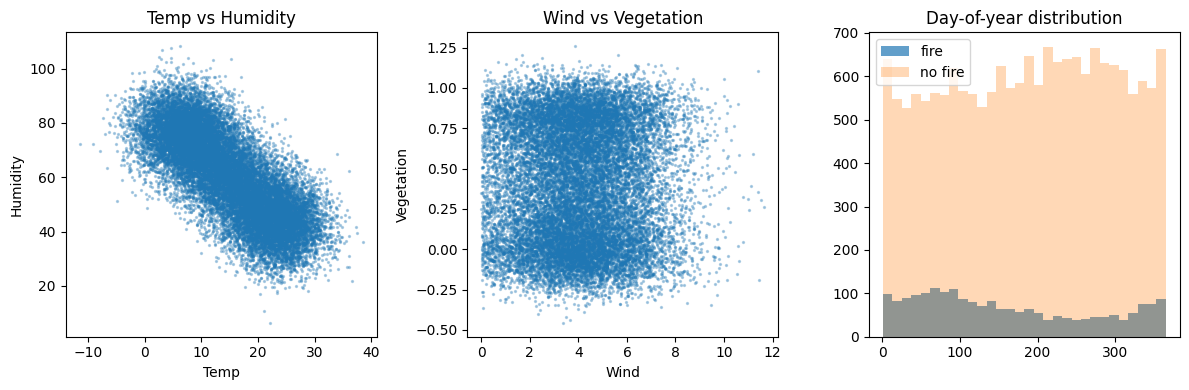

In [39]:
# Cell 7 - Visualizations
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(df['temperature'], df['humidity'], s=2, alpha=0.3)
plt.xlabel('Temp'); plt.ylabel('Humidity'); plt.title('Temp vs Humidity')
plt.subplot(1,3,2)
plt.scatter(df['wind_speed'], df['vegetation_index'], s=2, alpha=0.3)
plt.xlabel('Wind'); plt.ylabel('Vegetation'); plt.title('Wind vs Vegetation')
plt.subplot(1,3,3)
plt.hist(df.loc[df['fire']==1,'day_of_year'], bins=30, alpha=0.7, label='fire')
plt.hist(df.loc[df['fire']==0,'day_of_year'], bins=30, alpha=0.3, label='no fire')
plt.legend(); plt.title('Day-of-year distribution')
plt.tight_layout()

In [40]:
# Cell 8 - Feature engineering
df['temp_hum_ratio'] = df['temperature'] / (df['humidity']+1e-6)
df['is_dry'] = (df['humidity']<35).astype(int)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
else:
    df['month'] = ((df['day_of_year']-1)//30+1).clip(1,12)
df.fillna(df.median(numeric_only=True), inplace=True)
FEATURES = ["latitude","longitude","month","day_of_year","temperature","humidity",
            "wind_speed","precipitation","vegetation_index","temp_hum_ratio","is_dry"]
TARGET = "fire"
print("Using features:", FEATURES)

Using features: ['latitude', 'longitude', 'month', 'day_of_year', 'temperature', 'humidity', 'wind_speed', 'precipitation', 'vegetation_index', 'temp_hum_ratio', 'is_dry']


In [41]:
# Cell 9 - Train/val/test split + scaling
X = df[FEATURES].values; y = df[TARGET].values
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)

(14000, 11) (3000, 11) (3000, 11)


In [42]:
# Cell 10 - Random Forest baseline
rf = RandomForestClassifier(n_estimators=200,max_depth=12,random_state=42,n_jobs=-1,class_weight='balanced')
rf.fit(X_train_scaled,y_train)
y_pred = rf.predict(X_val_scaled)
print("Val acc:", accuracy_score(y_val,y_pred))
print(classification_report(y_val,y_pred))

Val acc: 0.8266666666666667
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2685
           1       0.15      0.14      0.14       315

    accuracy                           0.83      3000
   macro avg       0.53      0.52      0.52      3000
weighted avg       0.82      0.83      0.82      3000



<Axes: title={'center': 'RF feature importance'}>

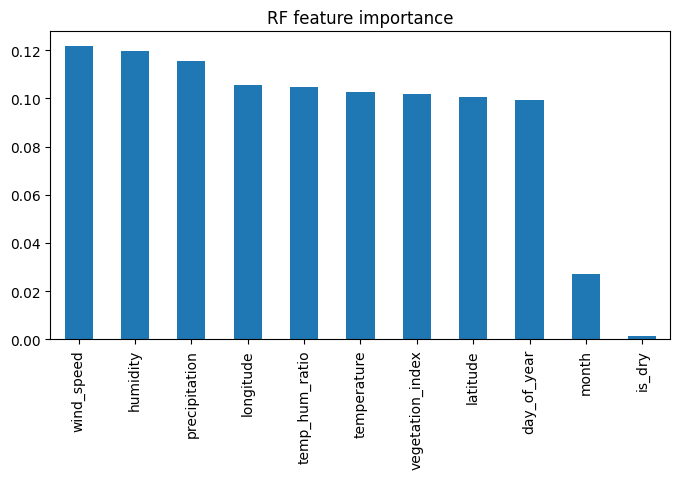

In [43]:
# Cell 11 - Feature importances
imp = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
imp.plot(kind='bar',figsize=(8,4),title="RF feature importance")

In [44]:
# Cell 12 - Optional XGBoost
if XGBOOST_AVAILABLE:
    xg = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss',n_estimators=200,random_state=42)
    xg.fit(X_train_scaled,y_train)
    y_pred_xg = xg.predict(X_val_scaled)
    print("Val acc (XGB):", accuracy_score(y_val,y_pred_xg))
    print(classification_report(y_val,y_pred_xg))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:45:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Val acc (XGB): 0.886
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2685
           1       0.14      0.02      0.03       315

    accuracy                           0.89      3000
   macro avg       0.52      0.50      0.48      3000
weighted avg       0.82      0.89      0.84      3000



In [45]:
# Cell 13 - Test evaluation
y_test_pred = rf.predict(X_test_scaled)
y_test_proba = rf.predict_proba(X_test_scaled)[:,1]
print("Test acc:", accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
print("ROC AUC:", roc_auc_score(y_test,y_test_proba))

Test acc: 0.8346666666666667
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2685
           1       0.16      0.13      0.14       315

    accuracy                           0.83      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.82      0.83      0.83      3000

ROC AUC: 0.5994703082971239


In [46]:
# Cell 14 - Save model + scaler
os.makedirs("models", exist_ok=True)
joblib.dump(rf,"models/rf_wildfire_model.joblib")
joblib.dump(scaler,"models/scaler.joblib")
print("Saved to models/")

Saved to models/


In [47]:
# Cell 15 - Example inference
example = {"latitude":36.5,"longitude":-120.2,"month":8,"day_of_year":220,"temperature":33.2,
           "humidity":22.5,"wind_speed":6.5,"precipitation":0.0,"vegetation_index":0.75,
           "temp_hum_ratio":33.2/(22.5+1e-6),"is_dry":1}
x_new = np.array([example[f] for f in FEATURES]).reshape(1,-1)
x_new_scaled = scaler.transform(x_new)
print("Prediction:", rf.predict(x_new_scaled)[0], "Prob:", rf.predict_proba(x_new_scaled)[0,1])

Prediction: 0 Prob: 0.22606289751108452


In [48]:
# Cell 16 - Prediction function
def predict_fire(sample_dict, model_path="models/rf_wildfire_model.joblib", scaler_path="models/scaler.joblib"):
    model = joblib.load(model_path); scaler = joblib.load(scaler_path)
    x = np.array([sample_dict[f] for f in FEATURES]).reshape(1,-1)
    x_scaled = scaler.transform(x)
    return {"label": int(model.predict(x_scaled)[0]), "probability": float(model.predict_proba(x_scaled)[0,1])}
print(predict_fire(example))

{'label': 0, 'probability': 0.22606289751108452}
